In [112]:
!pip install pandas matplotlib scikit-learn numpy imblearn

In [253]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler
)
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

### 2. Описание данных
Dataset: [NASA | Nearest Earth Objects (1910-2024)](https://www.kaggle.com/datasets/ivansher/nasa-nearest-earth-objects-1910-2024)

В космосе много опасных тел, одно из них - N.E.O. - "Ближайшие земные объекты". Некоторые такие тела действительно представляют опасность для планеты Земля, NASA классифицирует их как "is_hazardous". Этот набор данных содержит ВСЕ наблюдения NASA за подобными объектами с 1910 по 2024 год.

+ **neo_id**: уникальный идентификатор для каждого астероида.
+ **name**: название астероида.
+ **absolute_magnitude**: описывает внутреннюю светимость.
+ **estimated_diameter_min**: минимальный расчетный диаметр в километрах.
+ **estimated_diameter_max**: максимальный расчетный диаметр в километрах.
+ **orbiting_body**: планета, вокруг которой вращается астероид.
+ **relative_velocity**: скорость относительно планеты в км/ч.
+ **miss_distance**: пропущенное расстояние в километрах.
+ **is_hazardous**: логическая переменная, которая показывает, является ли астероид опасным или нет.

# Задание 1. Предварительная подготовка данных

In [188]:
# Загрузка данных
data = pd.read_csv('data/nearest_earth_objects.csv')

In [189]:
data.head(20)

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.50,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False
5,3656926,(2014 BT8),25.00,0.026580,0.059435,Earth,47477.649832,4.290521e+07,False
6,3421513,(2008 OX1),21.50,0.133216,0.297879,Earth,57853.295346,2.727908e+07,True
7,3541504,(2010 OF101),19.75,0.298233,0.666868,Earth,46972.486794,6.997593e+07,False
8,3836942,(2018 YH),21.70,0.121494,0.271669,Earth,37424.548382,5.657727e+06,True
9,3892166,(2019 UP13),23.45,0.054269,0.121350,Earth,38524.867869,6.166118e+07,False


In [190]:
data.dtypes

neo_id                      int64
name                       object
absolute_magnitude        float64
estimated_diameter_min    float64
estimated_diameter_max    float64
orbiting_body              object
relative_velocity         float64
miss_distance             float64
is_hazardous                 bool
dtype: object

#### Проверка дубликатов

In [195]:
duplicates = data.duplicated().sum()
print(f'Количество дубликатов: {duplicates}')
if duplicates > 0:
    data.drop_duplicates(inplace=True)
    print('Дубликаты удалены.')

Количество дубликатов: 0


#### Заполнение пропусков

In [198]:
data.fillna({
    'absolute_magnitude': 0,
    'estimated_diameter_min': 0,
    'estimated_diameter_max': 0,
    'relative_velocity': 0,
    'miss_distance': 0,
    'orbiting_body': 'other'
}, inplace=True)

#### Построение графика количества значений по каждому классу

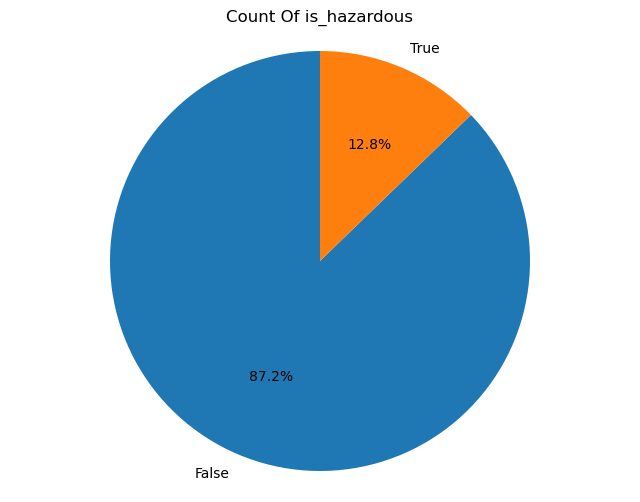

In [201]:
# График количества значений по классу is_hazardous
def is_hazardous_plot(counts):
    plt.figure(figsize=(8, 6))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Count Of is_hazardous')
    plt.axis('equal')
    plt.show()

is_hazardous_plot(data['is_hazardous'].value_counts())

Видно, что у нас дисбаланс классов, который нужно исправить

#### Проверка уникальности значений

In [205]:
# посчитать количество уникальных значений
unique_counts = data.select_dtypes("object").nunique()
unique_counts

name             33514
orbiting_body        1
dtype: int64

#### Определение числовых и категориальных признаков. Заполнить пропуски в данных

In [208]:
# удалить идентификатор, так как он не несёт никакой полезной для нас информации
data.drop(columns=['neo_id'], inplace=True)
numerical_cols = data.select_dtypes(include=['float64', 'int']).columns
data[numerical_cols] = data[numerical_cols].fillna(0)
numerical_cols

Index(['absolute_magnitude', 'estimated_diameter_min',
       'estimated_diameter_max', 'relative_velocity', 'miss_distance'],
      dtype='object')

In [210]:
categorical_cols = data.select_dtypes(include=['object']).columns
data[categorical_cols] = data[categorical_cols].fillna('other')
categorical_cols

Index(['name', 'orbiting_body'], dtype='object')

#### Применить стандартизацию к числовым признакам и закодировать категориальные признаки

In [213]:
# Создание экземпляра StandardScaler
scaler = StandardScaler()

# Стандартизация числовых признаков
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
data[numerical_cols]

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance
0,-1.298800,0.755596,0.755596,0.783537,0.799476
1,-1.518087,1.186911,1.186911,2.230715,0.686711
2,-0.507314,-0.068436,-0.068436,-0.992271,1.235756
3,-0.788275,0.130831,0.130831,1.054176,-0.536196
4,-0.079021,-0.258515,-0.258515,0.188485,1.038958
...,...,...,...,...,...
338194,1.935672,-0.486459,-0.486459,0.211610,1.084537
338195,1.973362,-0.487264,-0.487264,-1.133742,-0.579886
338196,-0.346618,-0.152801,-0.152801,-1.485978,0.574057
338197,0.327687,-0.361361,-0.361361,0.194617,-1.749816


In [215]:
# Создание экземпляра LabelEncoder
label_encoder = LabelEncoder()

# Применение LabelEncoder к каждому категориальному столбцу
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

In [216]:
data.head(20)

,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,30603,-1.298800,0.755596,0.755596,0,0.783537,0.799476,False
1,31395,-1.518087,1.186911,1.186911,0,2.230715,0.686711,True
2,32118,-0.507314,-0.068436,-0.068436,0,-0.992271,1.235756,False
3,736,-0.788275,0.130831,0.130831,0,1.054176,-0.536196,False
4,4880,-0.079021,-0.258515,-0.258515,0,0.188485,1.038958,False
5,7484,0.709039,-0.418061,-0.418061,0,-0.135724,0.065941,False
6,2982,-0.490182,-0.078322,-0.078322,0,0.257304,-0.686257,True
7,4305,-1.089793,0.447419,0.447419,0,-0.154860,1.369050,False
8,15221,-0.421655,-0.115667,-0.115667,0,-0.516535,-1.727048,True
9,16520,0.177955,-0.329843,-0.329843,0,-0.474855,0.968801,False


#### Разделить на тренировочную и обучающую выборки

In [220]:
target_column = "is_hazardous"
features = ['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 'miss_distance', 'relative_velocity']
X = data[features]
y = data[target_column]

In [222]:
print(X.shape, y.shape)

(338199, 5) (338199,)


In [224]:
# Избавиться от дисбаланса классов
# SMOTE создает синтетические примеры, основываясь на существующих данных
smt = SMOTE()
X_resampled, y_resampled = smt.fit_resample(X, y)

In [225]:
print(X_resampled.shape, y_resampled.shape)

(590074, 5) (590074,)


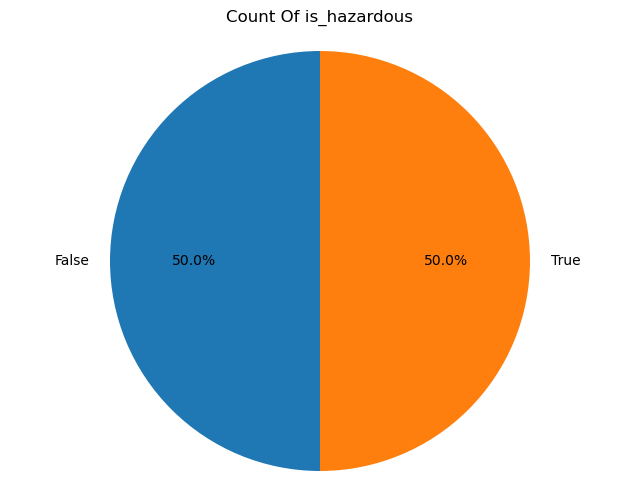

In [226]:
is_hazardous_plot(y_resampled.value_counts())

In [229]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.25, stratify=y_resampled, random_state=42
)
X_train.head(2)

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,miss_distance,relative_velocity
105024,-0.277749,-0.183739,-0.183739,0.205042,0.704377
300963,-0.507314,-0.068436,-0.068436,-1.621476,-0.362116


In [231]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(442555, 5) (442555,)
(147519, 5) (147519,)


In [232]:
X_train.head()

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,miss_distance,relative_velocity
105024,-0.277749,-0.183739,-0.183739,0.205042,0.704377
300963,-0.507314,-0.068436,-0.068436,-1.621476,-0.362116
42570,0.914620,-0.438506,-0.438506,-0.716444,-0.361983
494681,-1.069975,0.422453,0.422453,-1.404132,0.566744
486174,-0.653101,0.025609,0.025609,-0.824300,1.279109


In [236]:
X_test.head()

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,miss_distance,relative_velocity
17466,-2.227341,3.880526,3.880526,-0.144813,-1.179890
237894,-0.246912,-0.196691,-0.196691,0.501549,0.233182
358584,-0.789949,0.132484,0.132484,1.022162,-1.371978
420994,-0.857859,0.193050,0.193050,0.254652,0.293919
73710,-0.634089,0.012245,0.012245,0.042033,-1.257677


# Задание №2. Обучение модели деревья решений и вычисление метрик

In [239]:
def get_report(report):
    """Функция для вывода метрик"""
    print(f"Accuracy: {report['accuracy']:.2f}")
    print(f"Класс 1 (неопасные): Recall: {report['False']['recall']:.2f}, Precision: {report['False']['precision']:.2f}, F1-Score: {report['False']['f1-score']:.2f}")
    print(f"Класс 2 (опасные): Recall: {report['True']['recall']:.2f}, Precision: {report['True']['precision']:.2f}, F1-Score: {report['True']['f1-score']:.2f}")

In [241]:
def evaluate_model(_model, X_train, y_train, X_test, y_test):
    """Функция для оценки модели производительности"""
    # Предсказания на тренировочной выборке
    y_train_pred = _model.predict(X_train)

    # Предсказания на тестовой выборке
    y_test_pred = _model.predict(X_test)

    # Вычисление метрик для тренировочной выборки
    train_report = classification_report(y_train, y_train_pred, output_dict=True)

    # Вычисление метрик для тестовой выборки
    test_report = classification_report(y_test, y_test_pred, output_dict=True)

    # Вывод метрик
    print("Метрики на тренировочной выборке:")
    get_report(train_report)

    print("\nМетрики на тестовой выборке:")
    get_report(test_report)

In [243]:
# Создание модели
model = DecisionTreeClassifier()

# Обучение модели и вычисление метрик
model.fit(X_train, y_train)
evaluate_model(model, X_train, y_train, X_test, y_test)

Метрики на тренировочной выборке:
Accuracy: 1.00
Класс 1 (неопасные): Recall: 1.00, Precision: 1.00, F1-Score: 1.00
Класс 2 (опасные): Recall: 1.00, Precision: 1.00, F1-Score: 1.00

Метрики на тестовой выборке:
Accuracy: 0.92
Класс 1 (неопасные): Recall: 0.91, Precision: 0.92, F1-Score: 0.92
Класс 2 (опасные): Recall: 0.92, Precision: 0.91, F1-Score: 0.92


### Выводы: 
1. Модель идеально классифицировала все примеры в тренировочной выборке, что указывает на отсутствие ошибок.
2. Модель показала высокую точность на тестовой выборке, однако наблюдается небольшое снижение по сравнению с тренировочной выборкой.
3. Идеальные результаты на тренировочной выборке могут указывать на переобучение модели, поскольку она не справляется с некоторыми аспектами данных, которые не были представлены в тренировочном наборе.
4. Несмотря на небольшое снижение производительности на тестовой выборке, модель все еще показывает высокие показатели качества, что свидетельствует о ее способности обобщать информацию.

# Задание №3. Настройка гиперпараметров модели

In [246]:
# Определение параметров для GridSearch
param_grid = {
    'max_depth': range(1, 21),  # Максимальная глубина дерева
    'min_samples_split': range(2, 21)  # Минимальное количество образцов для разделения узла
}

# Создание модели DecisionTreeClassifier
dtc = DecisionTreeClassifier()

# Подбор гиперпараметров с помощью GridSearchCV
grid_search = GridSearchCV(dtc, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Получение лучших параметров
best_params = grid_search.best_params_
print(f"Лучшие параметры: {best_params}")

Лучшие параметры: {'max_depth': 20, 'min_samples_split': 2}


In [247]:
# Обучение модели с лучшими параметрами
best_model = grid_search.best_estimator_

# Вычисление и вывод метрик
evaluate_model(best_model, X_train, y_train, X_test, y_test)

Метрики на тренировочной выборке:
Accuracy: 0.89
Класс 1 (неопасные): Recall: 0.80, Precision: 0.98, F1-Score: 0.88
Класс 2 (опасные): Recall: 0.98, Precision: 0.83, F1-Score: 0.90

Метрики на тестовой выборке:
Accuracy: 0.87
Класс 1 (неопасные): Recall: 0.78, Precision: 0.96, F1-Score: 0.86
Класс 2 (опасные): Recall: 0.96, Precision: 0.82, F1-Score: 0.88


### Выводы:
1. Модель деревьев решений с параметрами глубины 20 и минимальным количеством образцов 2 демонстрирует хорошие результаты как на тренировочной, так и на тестовой выборках. Общая точность составляет 89% на тренировочной выборке и 87% на тестовой. Это свидетельствует о том, что модель хорошо обобщает данные и не переобучается.
2. Для класса "неопасные" модель показывает высокую точность (precision), что означает, что большинство предсказанных "неопасных" объектов действительно таковыми являются. Однако recall несколько ниже, что указывает на то, что некоторые "неопасные" объекты могут быть неправильно классифицированы как "опасные". Снижение метрик на тестовой выборке относительно тренировочной также говорит о некоторой потере качества обобщения.
3. Для класса "опасные" модель демонстрирует очень высокий recall, что говорит о том, что большинство "опасных" объектов правильно классифицируются. Однако precision немного ниже, что может указывать на наличие ложноположительных результатов. Снижение метрик на тестовой выборке также наблюдается, но в целом модель сохраняет хорошее качество.